In [93]:
from dotenv import load_dotenv

load_dotenv()

True

In [94]:
from langchain_ollama import ChatOllama

llm = ChatOllama(model="llama3.2")

In [95]:
def multiply_three(a, b, c):
  return a * b * c

def add_three(a, b, c):
  return a + b + c

class Book:
  def __init__(self, title, author, personal_description):
    self.title = title
    self.author = author
    self.personal_description = personal_description
    
def create_book_object(title, author):
  book = Book(title, author, "this is my personal description")
  return book


llm_with_tools = llm.bind_tools([multiply_three, add_three, create_book_object])

In [96]:
# state
from typing_extensions import TypedDict
from typing import List, Annotated
from langgraph.graph import add_messages
from langchain_core.messages import AnyMessage

def num_track_reducer(orig, new):
  return orig + 1

class CustomState(TypedDict):
  messages: Annotated[List[AnyMessage], add_messages]
  is_book: bool
  num_track: Annotated[int, num_track_reducer]
  my_message: str

In [97]:
# create node
from copy import deepcopy

def tool_calling_llm(state):
  return {
    "messages": [llm_with_tools.invoke(state["messages"])],
    "is_book": state["is_book"]
    # num_track needs to be here?
  }
  
def check_is_book(state):
  new_state = deepcopy(state)
  new_state['is_book'] = False
  for message in state['messages']:
    print(message)
    if ("title" in message.content.lower() or "book" in message.content.lower()) and "author" in message.content.lower():
    # if message contain book and author state is_book is True
      new_state['is_book'] = True
  return new_state

def random_a(state):
  new_state = deepcopy(state)
  new_state['my_message'] = new_state["my_message"] + ": this is random a"
  return new_state

def random_b(state):
  new_state = deepcopy(state)
  new_state['my_message'] = new_state["my_message"] + ": this is random B"
  return new_state

def converge_node(state):
  new_state = deepcopy(state)
  new_state['my_message'] = new_state['my_message'] + ": It is converging again"
  return new_state  

def book_node(state):
  new_state = deepcopy(state)
  new_state['my_message'] = new_state['my_message'] + ": This is defintely a book"
  return new_state


def non_book_node(state):
  new_state = deepcopy(state)
  new_state['my_message'] = new_state['my_message'] + ": This is defintely NOT!!!! a book"
  return new_state

In [98]:
# edges
from typing import Literal
import random

def conditional_edge(state) -> Literal["rand_a", "rand_b"]:
  if random.random() > 0.5:
    return "rand_a"
  
  return "rand_b"

def conditional_book(state) -> Literal["book_node", "non_book_node"]:
  if state['is_book']:
    return 'book_node'
  
  return 'non_book_node'

In [99]:
# graph builder

from langgraph.graph import StateGraph, START, END

builder = StateGraph(CustomState)
builder.add_node("tool_llm", tool_calling_llm)
builder.add_node("check_book", check_is_book)
builder.add_node("rand_a", random_a)
builder.add_node("rand_b", random_b)
# builder.add_node("converge", converge_node)
builder.add_node('book_node', book_node)
builder.add_node('non_book_node', non_book_node)

builder.add_edge(START, "check_book")
builder.add_edge("check_book", "tool_llm")
builder.add_conditional_edges("tool_llm", conditional_edge)
builder.add_conditional_edges("rand_a", conditional_book)
builder.add_conditional_edges("rand_b", conditional_book)
builder.add_edge("book_node", END)
builder.add_edge("non_book_node", END)


graph = builder.compile()


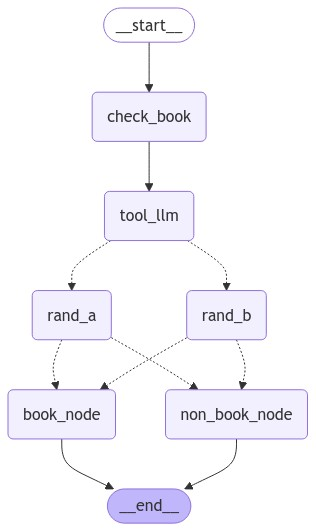

In [100]:
from IPython.display import display,Image

img = graph.get_graph().draw_mermaid_png()

# with open('test.png', 'wb') as file:
#   file.write(img

display(Image(img))



In [101]:
from langchain_core.messages import HumanMessage

orig_state = {
  "messages": [HumanMessage(content="""Hi, I like the book "the rosie project" by Author named Stephen""", name="Stephen")],
  "my_message": "This is Start"
}
response = graph.invoke(orig_state)

content='Hi, I like the book "the rosie project" by Author named Stephen' additional_kwargs={} response_metadata={} name='Stephen' id='5a6158cc-c3a2-4dd6-abfe-6cc2782a6791'


In [102]:
response

{'messages': [HumanMessage(content='Hi, I like the book "the rosie project" by Author named Stephen', additional_kwargs={}, response_metadata={}, name='Stephen', id='5a6158cc-c3a2-4dd6-abfe-6cc2782a6791'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2024-10-16T14:56:15.018221Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'create_book_object', 'arguments': {'author': 'Stephen', 'title': 'the rosie project'}}}]}, 'done_reason': 'stop', 'done': True, 'total_duration': 678261300, 'load_duration': 24359200, 'prompt_eval_count': 275, 'prompt_eval_duration': 29475000, 'eval_count': 27, 'eval_duration': 622537000}, id='run-cedbde90-e946-4aa8-8c7a-78953bcc4454-0', tool_calls=[{'name': 'create_book_object', 'args': {'author': 'Stephen', 'title': 'the rosie project'}, 'id': '21a2b2e1-081c-48eb-84ac-2cc69334e328', 'type': 'tool_call'}], usage_metadata={'input_tokens': 275, 'output_tokens': 27, 'total